# Oversampling and probability calibration

When we trained a neural network with an optimal set of hyperparameters we found that all predictions were capped at 0.2573042 with multiple examples outputting this value. In this notebook we rebalance the data and explore probability calibration to see if this resolves the issue.

In [1]:
import os
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from hyperopt import hp, fmin, rand, tpe, Trials
from hyperopt.pyll.stochastic import sample
import keras

Using TensorFlow backend.


In [2]:
os.chdir('..')

In [3]:
from src.data.utils import load_datasets
from src.models.neural_network import SimpleNeuralNetwork

## Load data

Now includes all features

In [4]:
RANDOM_SEED=42

In [5]:
%%time
train, dev, test, test_kaggle = load_datasets(random_seed=RANDOM_SEED)

Finished previous_application!
Finished installments_payments!
Finished pos_cash_balance!
Finished credit_card_balance!
CPU times: user 2min 47s, sys: 1min 43s, total: 4min 30s
Wall time: 5min 5s


In [6]:
train.shape

(184506, 1151)

In [7]:
# Features used in best LGBM:
FINAL_FEATURES =  pickle.load(open('models/lgbm_all_features_reduced_random_FEATURES.pickle', 'rb'))
len(FINAL_FEATURES)

212

In [8]:
train.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,POS_CASH_balance_SK_DPD_DEF_amax_sum_y,POS_CASH_balance_SK_DPD_DEF_amax_amin_y,POS_CASH_balance_SK_DPD_DEF_amax_amax_y,POS_CASH_balance_COUNT_COUNT_NAME_CONTRACT_STATUS_Active_y,POS_CASH_balance_COUNT_COUNT_NAME_CONTRACT_STATUS_Approved_y,POS_CASH_balance_COUNT_COUNT_NAME_CONTRACT_STATUS_Completed_y,POS_CASH_balance_COUNT_COUNT_NAME_CONTRACT_STATUS_Demand_y,POS_CASH_balance_COUNT_COUNT_NAME_CONTRACT_STATUS_Refused,POS_CASH_balance_COUNT_COUNT_NAME_CONTRACT_STATUS_Sent_proposal,POS_CASH_balance_COUNT_COUNT_NAME_CONTRACT_STATUS_Signed_y
170657,297783,0.0,0,74250.0,112500.0,6282.0,112500.0,0.018850,-15077,-7915,...,0.0,0.0,0.0,95.0,0.0,0.0,0.0,0.0,0.0,0.0
251121,390572,0.0,2,225000.0,810000.0,40500.0,810000.0,0.035792,-14311,-1858,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96789,212363,0.0,0,225000.0,1546020.0,42642.0,1350000.0,0.032561,-15236,-5751,...,0.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0
14042,116368,1.0,1,202500.0,444420.0,30195.0,337500.0,0.018850,-17688,-754,...,0.0,0.0,0.0,18.0,0.0,1.0,0.0,0.0,0.0,0.0
32597,137783,0.0,2,126000.0,1216201.5,35689.5,1062000.0,0.018029,-14030,-368,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
X_train = train[FINAL_FEATURES]
y_train = train['TARGET']
X_dev = dev[FINAL_FEATURES]
y_dev = dev['TARGET']

In [10]:
aggregated_features = [
    feat for feat in FINAL_FEATURES if feat.startswith(('bureau_balance_', 'bureau_', 'POS_CASH_balance_'))
]
len(aggregated_features)

165

## Oversample positive examples

In [11]:
y_train.mean()

0.08053396637507723

Only 8% positive examples. Not massively inbalanced but may be causing an issue. We oversample (randomly sample positive examples) until we have a 50-50 split of positive and negative examples.

In [12]:
num_negative_examples = (y_train==0).sum()
num_positive_examples = y_train.sum()

number_of_positive_examples_to_sample = num_negative_examples - num_positive_examples

In [13]:
number_of_positive_examples_to_sample

154788.0

In [14]:
train.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,POS_CASH_balance_SK_DPD_DEF_amax_sum_y,POS_CASH_balance_SK_DPD_DEF_amax_amin_y,POS_CASH_balance_SK_DPD_DEF_amax_amax_y,POS_CASH_balance_COUNT_COUNT_NAME_CONTRACT_STATUS_Active_y,POS_CASH_balance_COUNT_COUNT_NAME_CONTRACT_STATUS_Approved_y,POS_CASH_balance_COUNT_COUNT_NAME_CONTRACT_STATUS_Completed_y,POS_CASH_balance_COUNT_COUNT_NAME_CONTRACT_STATUS_Demand_y,POS_CASH_balance_COUNT_COUNT_NAME_CONTRACT_STATUS_Refused,POS_CASH_balance_COUNT_COUNT_NAME_CONTRACT_STATUS_Sent_proposal,POS_CASH_balance_COUNT_COUNT_NAME_CONTRACT_STATUS_Signed_y
170657,297783,0.0,0,74250.0,112500.0,6282.0,112500.0,0.018850,-15077,-7915,...,0.0,0.0,0.0,95.0,0.0,0.0,0.0,0.0,0.0,0.0
251121,390572,0.0,2,225000.0,810000.0,40500.0,810000.0,0.035792,-14311,-1858,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96789,212363,0.0,0,225000.0,1546020.0,42642.0,1350000.0,0.032561,-15236,-5751,...,0.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0
14042,116368,1.0,1,202500.0,444420.0,30195.0,337500.0,0.018850,-17688,-754,...,0.0,0.0,0.0,18.0,0.0,1.0,0.0,0.0,0.0,0.0
32597,137783,0.0,2,126000.0,1216201.5,35689.5,1062000.0,0.018029,-14030,-368,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
sampled_positive_examples = train[train['TARGET'] == 1].sample(
    int(number_of_positive_examples_to_sample),
    replace=True,
    random_state=RANDOM_SEED
)
sampled_positive_examples.shape

(154788, 1151)

In [16]:
train_after_sampling = train.append(sampled_positive_examples)

In [17]:
train_after_sampling['TARGET'].mean()

0.5

In [18]:
X_train = train_after_sampling[FINAL_FEATURES]
y_train = train_after_sampling['TARGET']

### Fill nulls with 0 for aggregated features

Same basic preprocessing steps as before.

In [19]:
X_train[aggregated_features].fillna(0, inplace=True)

/Users/stevengeorge/opt/anaconda3/envs/kaggle-home-credit/lib/python3.7/site-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [20]:
X_dev[aggregated_features].fillna(0, inplace=True)

### Fill other nulls with mean

In [21]:
X_train[set(FINAL_FEATURES) - set(aggregated_features)].shape

(339294, 47)

In [22]:
mean_imputer = SimpleImputer(strategy='mean')

In [23]:
X_train = mean_imputer.fit_transform(X_train)

In [24]:
X_train = pd.DataFrame(X_train, columns=FINAL_FEATURES)

In [25]:
X_dev = mean_imputer.transform(X_dev)

In [26]:
X_dev = pd.DataFrame(X_dev, columns=FINAL_FEATURES)

### Scale features

In [27]:
min_max_scalar = MinMaxScaler()

In [28]:
X_train = min_max_scalar.fit_transform(X_train)

In [29]:
X_dev = min_max_scalar.transform(X_dev)

## Fit neural network using new balanced training data

We use the optimal hyperparameters found in `11-Neural network revisited.ipynb`

In [30]:
new_neural_network = SimpleNeuralNetwork(
    number_of_inputs=212,
    number_of_layers=3,
    neurons_per_layer=57,
    dropout_rate_per_layer=0.03752158001340439,
    learning_rate=0.06627387542238576
).create_model()

In [31]:
# Compile model
rocauc = keras.metrics.AUC(num_thresholds=200, curve='ROC', summation_method='interpolation', name='roc_auc')
optimizer = keras.optimizers.Adam(learning_rate=0.06627387542238576)
new_neural_network.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[rocauc])

In [32]:
# Fit model
new_neural_network.fit(
    X_train,
    y_train,
    epochs=22,
    batch_size=69,
    validation_data=(X_dev, y_dev)
)

Train on 339294 samples, validate on 61502 samples
Epoch 1/22
339294/339294 [==============================] - 13s 37us/step - loss: 0.5984 - roc_auc: 0.7438 - val_loss: 0.5206 - val_roc_auc: 0.7495
Epoch 2/22
339294/339294 [==============================] - 12s 35us/step - loss: 0.5872 - roc_auc: 0.7562 - val_loss: 0.6456 - val_roc_auc: 0.7603
Epoch 3/22
339294/339294 [==============================] - 12s 35us/step - loss: 0.5820 - roc_auc: 0.7614 - val_loss: 0.4278 - val_roc_auc: 0.7565
Epoch 4/22
339294/339294 [==============================] - 12s 35us/step - loss: 0.5771 - roc_auc: 0.7665 - val_loss: 0.6817 - val_roc_auc: 0.7593
Epoch 5/22
339294/339294 [==============================] - 12s 35us/step - loss: 0.5746 - roc_auc: 0.7685 - val_loss: 0.4867 - val_roc_auc: 0.7569
Epoch 6/22
339294/339294 [==============================] - 12s 35us/step - loss: 0.5720 - roc_auc: 0.7711 - val_loss: 0.5322 - val_roc_auc: 0.7550
Epoch 7/22
339294/339294 [==============================] - 1

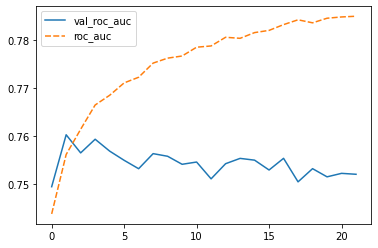

In [33]:
sns.lineplot(data=pd.DataFrame(new_neural_network.history.history)[['val_roc_auc', 'roc_auc']])

In [34]:
training_predictions = new_neural_network.predict(X_train)

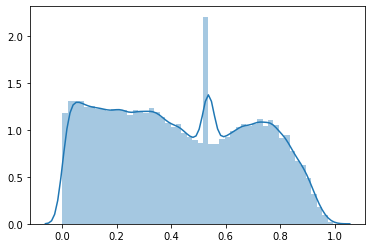

In [35]:
sns.distplot(training_predictions)

These hyperparameters don't work for this balanced dataset and lead to high variance. We need to perform Bayes search again to find the optimal hyperparameters for this 'new' problem.

## Bayes search

In [36]:
def objective(hyperparameters):
    
    # Hacky workaround for bug in package which saves integer hyperparameters as floats in the final dictionary. We explicitly cast as integers to avoid lightgbm errors.
    for hyper in ['number_of_layers', 'neurons_per_layer', 'epochs', 'batch_size']:
        try:
            as_int = int(hyperparameters[hyper])
            hyperparameters[hyper] = as_int
        except:
            continue
    
    # Machine learning model
    simple_neural_network = SimpleNeuralNetwork(
        number_of_inputs=len(FINAL_FEATURES),
        epochs=20,
        **hyperparameters
    )
    
    # Training 
    simple_neural_network.compile_model()
    simple_neural_network.fit(X_train, y_train, (X_dev, y_dev))
    
    # Making predictions and evaluating
    predictions = simple_neural_network.predict_proba(X_dev)
    roc_auc = roc_auc_score(y_dev, predictions)
    
    return -roc_auc  # Has to be a minimisation problem

In [37]:
space = {
    'number_of_layers': hp.uniformint('number_of_layers', 1, 5),
    'neurons_per_layer': hp.uniformint('neurons_per_layer', 30, 250),
    'dropout_rate_per_layer': hp.uniform('dropout_rate_per_layer', low=0, high=1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.3)),
#     'epochs': hp.uniformint('epochs', 10, 50),
    'batch_size': hp.loguniform('batch_size', np.log(32), np.log(1024))
}

In [38]:
sample(space)

{'batch_size': 118.66725585492232,
 'dropout_rate_per_layer': 0.7596607738753606,
 'learning_rate': 0.00626697542390014,
 'neurons_per_layer': 132,
 'number_of_layers': 3}

In [39]:
%%time
bayes_trials = Trials()

best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=40, trials=bayes_trials)

100%|██████████| 40/40 [2:02:44<00:00, 184.11s/trial, best loss: -0.75483210143845]    
CPU times: user 4h 8min 49s, sys: 1h 11min, total: 5h 19min 49s
Wall time: 2h 2min 44s


In [40]:
best

{'batch_size': 364.3454784295952,
 'dropout_rate_per_layer': 0.1507127516415241,
 'learning_rate': 0.00854373359882833,
 'neurons_per_layer': 31.0,
 'number_of_layers': 5.0}

## Neural network with optimal hyperparameters

We use the scikit-learn wrapper `Keras Classifier` to utilise scikit-learn classes later (particularly `CalibratedClassifierCV` which expects our model to have certain methods).

In [31]:
from keras.wrappers.scikit_learn import KerasClassifier

In [32]:
def create_model():
    model = SimpleNeuralNetwork(
        number_of_inputs=212,
        number_of_layers=int(best['number_of_layers']),
        neurons_per_layer=int(best['neurons_per_layer']),
        dropout_rate_per_layer=best['dropout_rate_per_layer'],
        learning_rate=best['learning_rate']
    ).create_model()

    # Compile model
    rocauc = keras.metrics.AUC(num_thresholds=200, curve='ROC', summation_method='interpolation', name='roc_auc')
    optimizer = keras.optimizers.Adam(learning_rate=best['learning_rate'])
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[rocauc])
    
    return model

In [33]:
# Try more epochs
best_new_neural_network = KerasClassifier(build_fn=create_model, epochs=40, batch_size=int(best['batch_size']), validation_data=(X_dev, y_dev))

In [34]:
best_new_neural_network.fit(X_train, y_train)

Train on 339294 samples, validate on 61502 samples
Epoch 1/40
339294/339294 [==============================] - 8s 24us/step - loss: 0.6233 - roc_auc: 0.7103 - val_loss: 0.5887 - val_roc_auc: 0.7485
Epoch 2/40
339294/339294 [==============================] - 7s 20us/step - loss: 0.6087 - roc_auc: 0.7301 - val_loss: 0.7321 - val_roc_auc: 0.7454
Epoch 3/40
339294/339294 [==============================] - 7s 20us/step - loss: 0.6044 - roc_auc: 0.7353 - val_loss: 0.6723 - val_roc_auc: 0.7490
Epoch 4/40
339294/339294 [==============================] - 7s 20us/step - loss: 0.6015 - roc_auc: 0.7389 - val_loss: 0.5890 - val_roc_auc: 0.7502
Epoch 5/40
339294/339294 [==============================] - 7s 20us/step - loss: 0.5995 - roc_auc: 0.7413 - val_loss: 0.6775 - val_roc_auc: 0.7470
Epoch 6/40
339294/339294 [==============================] - 7s 20us/step - loss: 0.5982 - roc_auc: 0.7426 - val_loss: 0.6744 - val_roc_auc: 0.7519
Epoch 7/40
339294/339294 [==============================] - 7s 20us

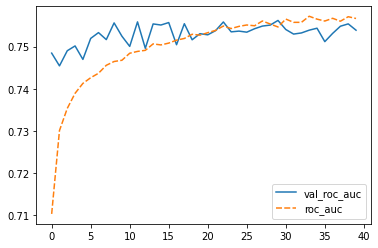

In [35]:
sns.lineplot(data=pd.DataFrame(best_new_neural_network.model.history.history)[['val_roc_auc', 'roc_auc']])

In [36]:
roc_auc_score(y_dev, best_new_neural_network.predict_proba(X_dev)[:,1])

0.7539444476017092

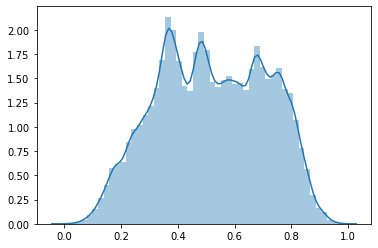

In [37]:
sns.distplot(best_new_neural_network.predict_proba(X_train)[:,1])

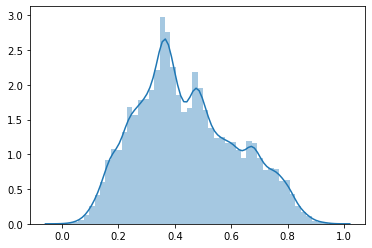

In [38]:
sns.distplot(best_new_neural_network.predict_proba(X_dev)[:,1])

Looks like rebalancing the data has led to the desired spread in values ranging from 0 to 1 without any peculiar spikes.

## Probability calibration

In [39]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

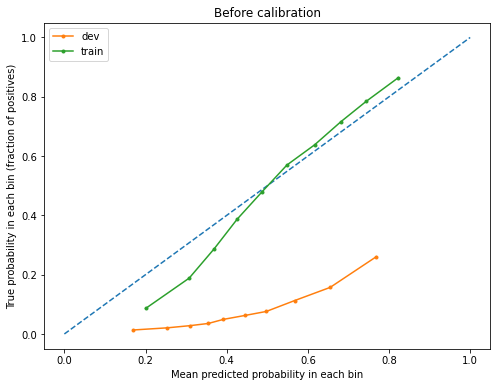

In [40]:
# Predict probabilities
predictions_dev = best_new_neural_network.predict_proba(X_dev)[:,1]
predictions_train = best_new_neural_network.predict_proba(X_train)[:,1]

# Calibration curve
fop_dev, mpv_dev = calibration_curve(y_dev, predictions_dev, n_bins=10, strategy='quantile')
fop_train, mpv_train = calibration_curve(y_train, predictions_train, n_bins=10, strategy='quantile')

# Plot perfectly calibrated
plt.figure(figsize=(8,6))

plt.title('Before calibration')

plt.plot([0, 1], [0, 1], linestyle='--')
# Plot model reliability
plt.plot(mpv_dev, fop_dev, marker='.', label='dev')
plt.plot(mpv_train, fop_train, marker='.', label='train')

plt.xlabel('Mean predicted probability in each bin')
plt.ylabel('True probability in each bin (fraction of positives)')

plt.legend()

plt.show()

Model looks reasonably well calibrated to training data with signs that the model overpredicts initially (line under curve) then underpredicts (line above curve).

Calibration on the dev set is very poor (massively overpredicting).

In [41]:
calibrated_model = CalibratedClassifierCV(best_new_neural_network, method='sigmoid', cv='prefit')

In [42]:
calibrated_model.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fbb45622950>,
                       cv='prefit', method='sigmoid')

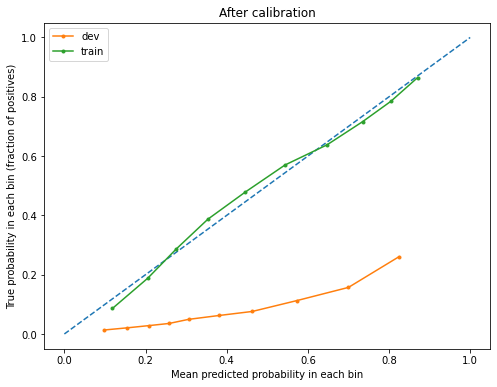

In [43]:
# Predict probabilities
predictions_dev = calibrated_model.predict_proba(X_dev)[:,1]
predictions_train = calibrated_model.predict_proba(X_train)[:,1]

# Calibration curve
fop_dev, mpv_dev = calibration_curve(y_dev, predictions_dev, n_bins=10, strategy='quantile')
fop_train, mpv_train = calibration_curve(y_train, predictions_train, n_bins=10, strategy='quantile')

# Plot perfectly calibrated
plt.figure(figsize=(8,6))

plt.title('After calibration')

plt.plot([0, 1], [0, 1], linestyle='--')
# Plot model reliability
plt.plot(mpv_dev, fop_dev, marker='.', label='dev')
plt.plot(mpv_train, fop_train, marker='.', label='train')

plt.xlabel('Mean predicted probability in each bin')
plt.ylabel('True probability in each bin (fraction of positives)')

plt.legend()

plt.show()

In [44]:
roc_auc_score(y_train, best_new_neural_network.predict_proba(X_train)[:,1])

0.7868288700527704

In [45]:
roc_auc_score(y_train, calibrated_model.predict_proba(X_train)[:,1])

0.7868288709561722

ROC AUC is unchanged. This is because ROC AUC only depends on rank ordering, which is unchanged after sigmoid calibration.

__Conclusions:__

- We rebalanced the data to 50/50 to stop the scores being skewed to lower ranges.
- This led to a spread of scores but ROC AUC remained comparable to before.
- The undesired consequence is that it forced our model to become overly cautious, predicting higher scores across the board.
- This is evident in the calibration curve for the unbalanced dev set (well below the perfect line) and the dev log loss (a measure of how accurate the probability predictions are). The log loss was 0.6109 in the final epoch vs 0.2519 for the original neural network. 
- To have better calibration we can explore tuning the resampling proportion.
- For the purposes of this competition, calibration is not that important because the target metric is ROC AUC.
- However in a commercial context, calibrated scores may be more desirable.